# **1. Data augmentation**
---
---
* Mismo set de entrenamiento
* Aumento de datos a los 1910 muestras (mediana)

## **Carga de datos**

In [14]:
import pandas as pd

df = pd.read_csv("df_augmented_1528_samples.csv")
df.fillna(0, inplace=True)

In [15]:
df['database'].value_counts()

database
INTER1SP    6588
SMC         5143
EMS         2233
EW          2018
MESD         871
EmoFilm      363
Name: count, dtype: int64

In [16]:
import numpy as np

features = np.load("df_augmented_1528_w2v2_53es_layer6.npz")

features = list(features.values())

In [17]:
# Verify alignment
assert len(df) == len(features), "Mismatch between df and features length"

In [18]:
features

[array([-0.8755,  0.7793,  0.349 , ...,  2.826 ,  1.    ,  1.946 ],
       dtype=float16),
 array([-0.2903,  0.2389,  0.4336, ...,  2.57  ,  1.183 ,  0.701 ],
       dtype=float16),
 array([-1.484 ,  0.683 ,  0.284 , ...,  1.969 , -0.1903,  1.569 ],
       dtype=float16),
 array([-1.024 ,  0.487 ,  0.3076, ...,  3.906 ,  0.1198,  0.1271],
       dtype=float16),
 array([ 0.01412, -0.2668 , -0.091  , ...,  1.441  , -0.4973 ,  0.8276 ],
       dtype=float16),
 array([-0.02496,  0.883  ,  0.429  , ...,  2.244  , -0.05035,  0.7354 ],
       dtype=float16),
 array([-0.2944, -0.0778,  0.0585, ...,  1.598 ,  1.144 ,  1.698 ],
       dtype=float16),
 array([-0.92  ,  0.4768,  0.3188, ...,  1.573 ,  0.1818,  1.34  ],
       dtype=float16),
 array([-0.5615, -0.0929, -0.3257, ...,  1.896 , -0.7964,  0.9497],
       dtype=float16),
 array([-1.274 ,  0.4607,  0.5684, ...,  2.285 , -0.1792,  2.463 ],
       dtype=float16),
 array([-1.19   ,  0.9272 ,  1.348  , ...,  1.953  ,  0.08716,  0.828  ],
    

## **Preparación de datos**

### **Hacer multioutput**

In [19]:
e_dbs = ['SMC', 'EMS', 'INTER1SP', 'EmoFilm']
m_dbs = ['EmoWisconsin', 'MESD', ]

df['accent'] = df['database'].apply(lambda x: 'spain' if x in e_dbs else 'mex')

In [20]:
# Codificar emociones y género como variables dummy (0/1)
y_emotion = pd.get_dummies(df["new_emotion"])  # columnas: positive, neutral, negative
y_gender = pd.get_dummies(df["gender"])        # columnas: female, male, child
y_accent = pd.get_dummies(df["accent"]) 

# Unir ambos en una sola matriz de salida
y = pd.concat([y_gender, y_accent, y_emotion], axis=1).values


### **Partición de datos**

*EN multioutput_DA se realiza la declaración del set.*

In [21]:
import numpy as np

features = np.array(features)  # convierte a ndarray
X_train = features[df["set"] == "train"]
X_test = features[df["set"] == "test"]


# Filtrar train y test directamente
df_train = df[df["set"] == "train"].reset_index(drop=True)
df_test = df[df["set"] == "test"].reset_index(drop=True)


# `features` y `y` están alineados con `df` original
X_train = features[df["set"] == "train"].copy()
X_test = features[df["set"] == "test"].copy()

y_train = y[df["set"] == "train"]
y_test = y[df["set"] == "test"]

# También puedes extraer columnas específicas desde df_test
test_paths = df_test["path"].reset_index(drop=True)
test_databases = df_test["database"].reset_index(drop=True)


In [22]:
from sklearn.preprocessing import StandardScaler

# Escalado de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Convierte explícitamente las etiquetas
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [23]:
X_train.shape, y_train.shape

((13938, 1024), (13938, 12))

In [26]:
df_train['new_emotion'].to_csv("train_augmentation_1528.csv", index=False)

## **Entrenamiento**
1. Grid-Search Cross-validation Multioutput
2. Basado en Macro-F1
3. Entrenamiento en Chain


In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Escalado de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Definición del modelo base ---
base_mlp = MLPClassifier(max_iter=500, random_state=42)

# --- Búsqueda de hiperparámetros ---
param_grid = {
    'estimator__hidden_layer_sizes': [(512, 256, 256), (512, 512, 256), (512, 512, 512, 256)],
    'estimator__activation': ['relu'],
    'estimator__learning_rate_init': [0.001, 0.0005, 0.0001],
    'estimator__alpha': [0.0001, 0.001],
}

# --- Clasificador multietiqueta ---
multioutput = MultiOutputClassifier(base_mlp)

# --- Métrica de evaluación (F1 macro promedio sobre etiquetas) ---
f1_weighted_scorer = make_scorer(f1_score, average='weighted')

# --- GridSearchCV ---
grid_search = GridSearchCV(
    estimator=multioutput,
    param_grid=param_grid,
    scoring=f1_weighted_scorer,
    cv=3,
    verbose=3,
    n_jobs=-1  # paraleliza en todos los cores disponibles
)

In [48]:
# --- Entrenamiento ---
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\model_selection\_search.py:412: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


GridSearchCV(cv=3,
             estimator=MultiOutputClassifier(estimator=MLPClassifier(max_iter=500,
                                                                     random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__activation': ['relu'],
                         'estimator__alpha': [0.0001, 0.001],
                         'estimator__hidden_layer_sizes': [(512, 256, 256),
                                                           (512, 512, 256),
                                                           (512, 512, 512,
                                                            256)],
                         'estimator__learning_rate_init': [0.001, 0.0005,
                                                           0.0001]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=3)

In [49]:
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

# --- Resultados ---
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\nF1-score (weighted) en el set de prueba:")
y_pred = grid_search.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))

# ====================================
# 5. Reportes separados: Emociones y Género
# ====================================

# Separar emociones (columnas 0-6) y género (columnas 7-9)
y_test_gender = y_test[:, :3]
y_test_accent = y_test[:, 3:5]
y_test_emotions = y_test[:, 5:]

y_pred_gender = y_pred[:, :3]
y_pred_accent = y_pred[:, 3:5]
y_pred_emotions = y_pred[:, 5:]

emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
gender_labels = ['female', 'male', 'child']
accent_labels = ['mex', 'spain']

# ======= Reporte Emociones ========
print("\n===== Reporte de EMOCIONES =====")

print("\nClassification Report (Emociones):")
print(classification_report(y_test_emotions, y_pred_emotions, target_names=emotion_labels, digits=6))

print("Accuracy (Emociones):", accuracy_score(y_test_emotions, y_pred_emotions))
print("Hamming Loss (Emociones):", hamming_loss(y_test_emotions, y_pred_emotions))
print("F1 weighted (Emociones):", f1_score(y_test_emotions, y_pred_emotions, average="weighted"))

# ======= Reporte Género ========a
print("\n===== Reporte de GÉNERO =====")

print("\nClassification Report (Género):")
print(classification_report(y_test_gender, y_pred_gender, target_names=gender_labels, digits=6))

print("Accuracy (Género):", accuracy_score(y_test_gender, y_pred_gender))
print("Hamming Loss (Género):", hamming_loss(y_test_gender, y_pred_gender))
print("F1 weighted (Género):", f1_score(y_test_gender, y_pred_gender, average="weighted"))

# ======= Reporte tipo ========a
print("\n===== Reporte de TIPO =====")

print("\nClassification Report (Acento):")
print(classification_report(y_test_accent, y_pred_accent, target_names=accent_labels, digits=6))

print("Accuracy (Género):", accuracy_score(y_test_accent, y_pred_accent))
print("Hamming Loss (Género):", hamming_loss(y_test_accent, y_pred_accent))
print("F1 weighted (Género):", f1_score(y_test_accent, y_pred_accent, average="weighted"))

Mejores hiperparámetros encontrados:
{'estimator__activation': 'relu', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (512, 512, 512, 256), 'estimator__learning_rate_init': 0.001}

F1-score (weighted) en el set de prueba:
0.9631013606532793

===== Reporte de EMOCIONES =====

Classification Report (Emociones):
              precision    recall  f1-score   support

       anger   0.875648  0.871134  0.873385       388
     disgust   0.931925  0.876380  0.903299       453
        fear   0.834711  0.839335  0.837017       361
   happiness   0.921450  0.798429  0.855540       382
     neutral   0.928116  0.913978  0.920993      1116
     sadness   0.913649  0.879357  0.896175       373
    surprise   0.946078  0.941463  0.943765       205

   micro avg   0.910354  0.879805  0.894818      3278
   macro avg   0.907368  0.874297  0.890025      3278
weighted avg   0.910846  0.879805  0.894637      3278
 samples avg   0.862213  0.879805  0.868060      3278

Accuracy (Emociones): 0.8

c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
from sklearn.metrics import hamming_loss, accuracy_score

# Hamming Loss: porcentaje de etiquetas mal clasificadas (por etiqueta)
hl = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {hl:.4f}")

# Exact Match Ratio (Subset Accuracy): solo acierta si TODAS las etiquetas coinciden
emr = accuracy_score(y_test, y_pred)
print(f"Exact Match Ratio: {emr:.4f}")


Hamming Loss: 0.0181
Exact Match Ratio: 0.8414


## **Entrenamiento Chain**
{'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (512, 256, 256), 'estimator__learning_rate_init': 0.001}


In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, f1_score

mlp = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    hidden_layer_sizes=(512, 256, 256),
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42,
)


chain = ClassifierChain(mlp, chain_method='predict_proba', verbose=True)


chain.fit(X_train, y_train)


[Chain] .................. (1 of 12) Processing order 0, total=  58.7s
[Chain] .................. (2 of 12) Processing order 1, total=  51.3s
[Chain] .................. (3 of 12) Processing order 2, total=  48.7s
[Chain] .................. (4 of 12) Processing order 3, total=  45.2s
[Chain] .................. (5 of 12) Processing order 4, total=  36.8s
[Chain] .................. (6 of 12) Processing order 5, total= 1.2min
[Chain] .................. (7 of 12) Processing order 6, total= 1.1min
[Chain] .................. (8 of 12) Processing order 7, total= 2.0min
[Chain] .................. (9 of 12) Processing order 8, total= 1.5min
[Chain] ................. (10 of 12) Processing order 9, total= 1.1min
[Chain] ................ (11 of 12) Processing order 10, total=  58.4s
[Chain] ................ (12 of 12) Processing order 11, total= 1.4min


ClassifierChain(base_estimator=MLPClassifier(hidden_layer_sizes=(512, 256, 256),
                                             max_iter=1000, random_state=42),
                chain_method='predict_proba', verbose=True)

In [51]:
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

print("\nF1-score (weighted) en el set de prueba:")
y_pred = chain.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))

# ====================================
# 5. Reportes separados: Emociones y Género
# ====================================

# Separar emociones (columnas 0-6) y género (columnas 7-9)
y_test_gender = y_test[:, :3]
y_test_accent = y_test[:, 3:5]
y_test_emotions = y_test[:, 5:]

y_pred_gender = y_pred[:, :3]
y_pred_accent = y_pred[:, 3:5]
y_pred_emotions = y_pred[:, 5:]

emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
gender_labels = ['female', 'male', 'child']
accent_labels = ['mex', 'spain']

# ======= Reporte Emociones ========
print("\n===== Reporte de EMOCIONES =====")

print("\nClassification Report (Emociones):")
print(classification_report(y_test_emotions, y_pred_emotions, target_names=emotion_labels, digits=6))

print("Accuracy (Emociones):", accuracy_score(y_test_emotions, y_pred_emotions))
print("Hamming Loss (Emociones):", hamming_loss(y_test_emotions, y_pred_emotions))
print("F1 weighted (Emociones):", f1_score(y_test_emotions, y_pred_emotions, average="weighted"))

# ======= Reporte Género ========a
print("\n===== Reporte de GÉNERO =====")

print("\nClassification Report (Género):")
print(classification_report(y_test_gender, y_pred_gender, target_names=gender_labels,  digits=6))

print("Accuracy (Género):", accuracy_score(y_test_gender, y_pred_gender))
print("Hamming Loss (Género):", hamming_loss(y_test_gender, y_pred_gender))
print("F1 weighted (Género):", f1_score(y_test_gender, y_pred_gender, average="weighted"))

# ======= Reporte tipo ========a
print("\n===== Reporte de TIPO =====")

print("\nClassification Report (Acento):")
print(classification_report(y_test_accent, y_pred_accent, target_names=accent_labels, digits=6))

print("Accuracy (Género):", accuracy_score(y_test_accent, y_pred_accent))
print("Hamming Loss (Género):", hamming_loss(y_test_accent, y_pred_accent))
print("F1 weighted (Género):", f1_score(y_test_accent, y_pred_accent, average="weighted"))


F1-score (weighted) en el set de prueba:
0.9638155219666792

===== Reporte de EMOCIONES =====

Classification Report (Emociones):
              precision    recall  f1-score   support

       anger   0.877551  0.886598  0.882051       388
     disgust   0.922374  0.891832  0.906846       453
        fear   0.833803  0.819945  0.826816       361
   happiness   0.872727  0.879581  0.876141       382
     neutral   0.935018  0.928315  0.931655      1116
     sadness   0.873351  0.887399  0.880319       373
    surprise   0.901869  0.941463  0.921241       205

   micro avg   0.898808  0.896888  0.897847      3278
   macro avg   0.888099  0.890733  0.889296      3278
weighted avg   0.898973  0.896888  0.897847      3278
 samples avg   0.883771  0.896888  0.888143      3278

Accuracy (Emociones): 0.8706528370957901
Hamming Loss (Emociones): 0.029155408350039224
F1 weighted (Emociones): 0.897847332667722

===== Reporte de GÉNERO =====

Classification Report (Género):
              precision

c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

# **Gráficas**

In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Separar las predicciones ---
n_emotions = y_emotion.shape[1]
n_gender = y_gender.shape[1]
n_accent = y_accent.shape[1]

# --- Obtener etiquetas predichas y verdaderas ---
gender_true = np.argmax(y_test[:, :n_gender], axis=1)
gender_pred = np.argmax(y_pred[:, :n_gender], axis=1)

accent_true = np.argmax(y_test[:, n_gender:n_gender + n_accent], axis=1)
accent_pred = np.argmax(y_pred[:, n_gender:n_gender + n_accent], axis=1)

emotion_true = np.argmax(y_test[:, n_gender + n_accent:], axis=1)
emotion_pred = np.argmax(y_pred[:, n_gender + n_accent:], axis=1)

emotion_labels = y_emotion.columns.tolist()
gender_labels = ['child', 'female', 'male']
accent_labels = y_accent.columns.tolist()

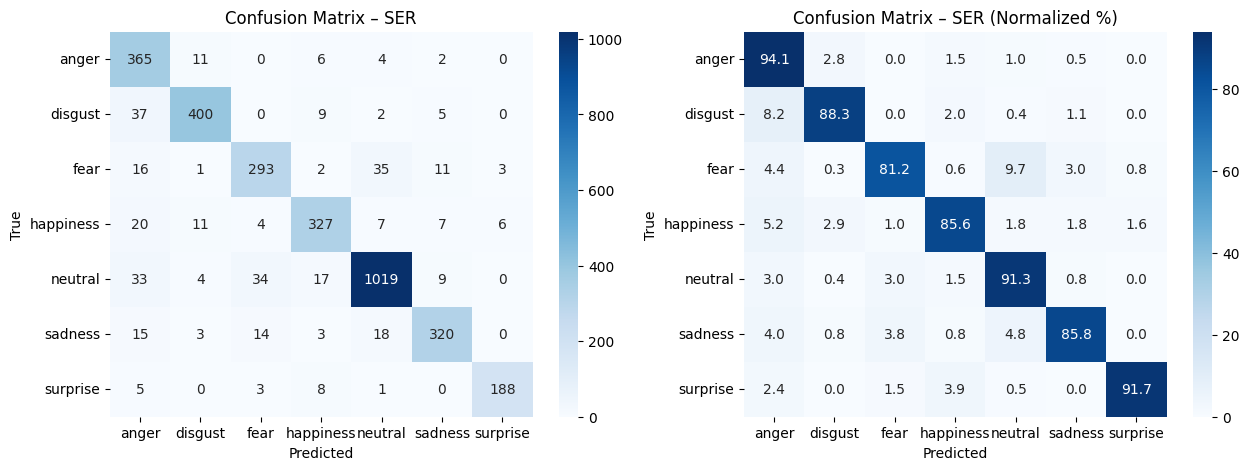

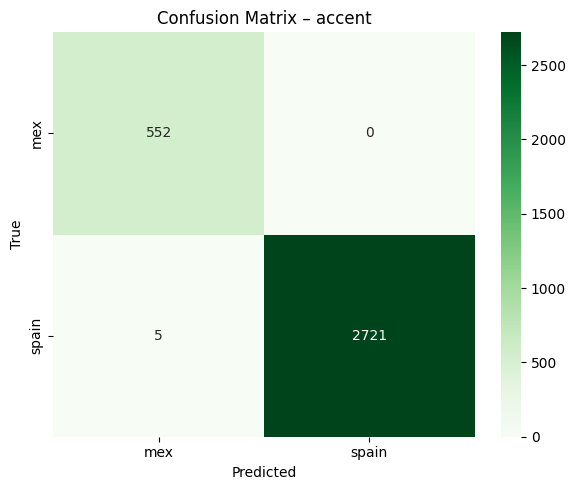

In [53]:
# --- Heatmap para emociones ---
#--------------------------------------------------
#--------------------------------------------------
#--------------------------------------------------
cm_emotion = confusion_matrix(emotion_true, emotion_pred, labels=range(len(emotion_labels)))
cm_emotion_norm = cm_emotion.astype('float') / cm_emotion.sum(axis=1, keepdims=True)


# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(cm_emotion, annot=True, fmt='d', 
            xticklabels=emotion_labels, yticklabels=emotion_labels, 
            cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix – SER")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_emotion_norm * 100, annot=True, fmt='.1f',
            xticklabels=emotion_labels, yticklabels=emotion_labels, 
            cmap='Blues', ax=axes[1])
axes[1].set_title("Confusion Matrix – SER (Normalized %)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")




# --- Heatmap para género ---
cm_accent = confusion_matrix(accent_true, accent_pred, labels=range(len(accent_labels)))
cm_accent_norm = cm_accent.astype('float') / cm_accent.sum(axis=1, keepdims=True)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_accent, annot=True, fmt='d', xticklabels=accent_labels, yticklabels=accent_labels, cmap='Greens')
plt.title("Confusion Matrix – accent")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


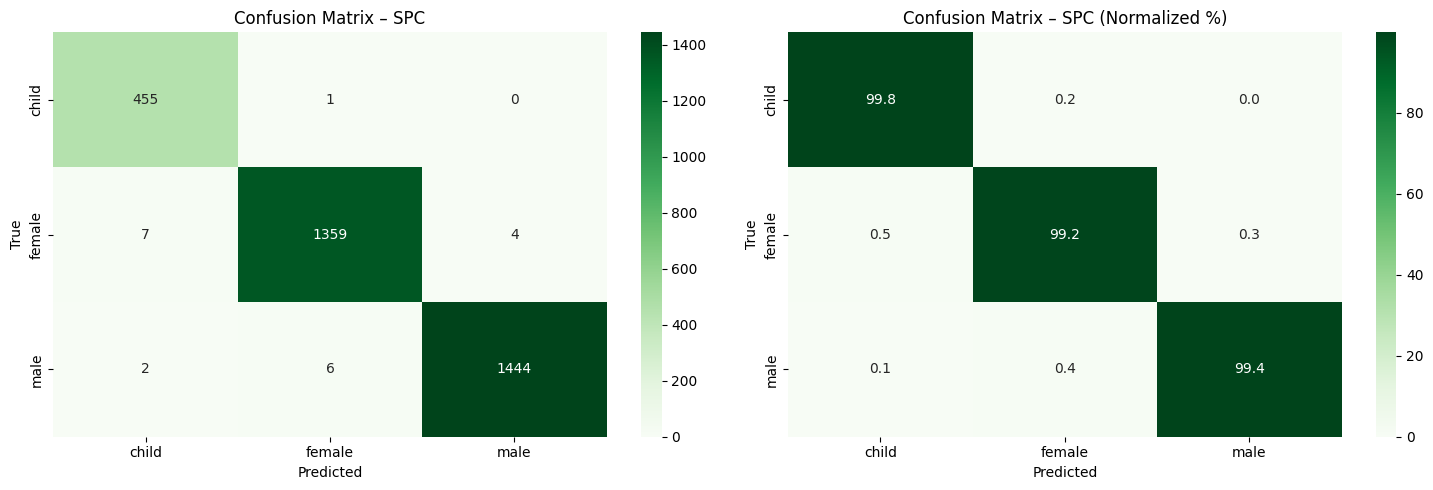

In [54]:
# --- Heatmap para género ---
#--------------------------------------------------
#--------------------------------------------------
#--------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
cm_gender = confusion_matrix(gender_true, gender_pred, labels=range(len(gender_labels)))
cm_gender_norm = cm_gender.astype('float') / cm_gender.sum(axis=1, keepdims=True)

sns.heatmap(cm_gender, annot=True, fmt='d', 
            xticklabels=gender_labels, yticklabels=gender_labels, 
            cmap='Greens', ax=axes[0])
axes[0].set_title("Confusion Matrix – SPC")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_gender_norm * 100, annot=True, fmt='.1f',
            xticklabels=gender_labels, yticklabels=gender_labels, 
            cmap='Greens', ax=axes[1])
axes[1].set_title("Confusion Matrix – SPC (Normalized %)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# Estilo general
plt.tight_layout()
plt.show()

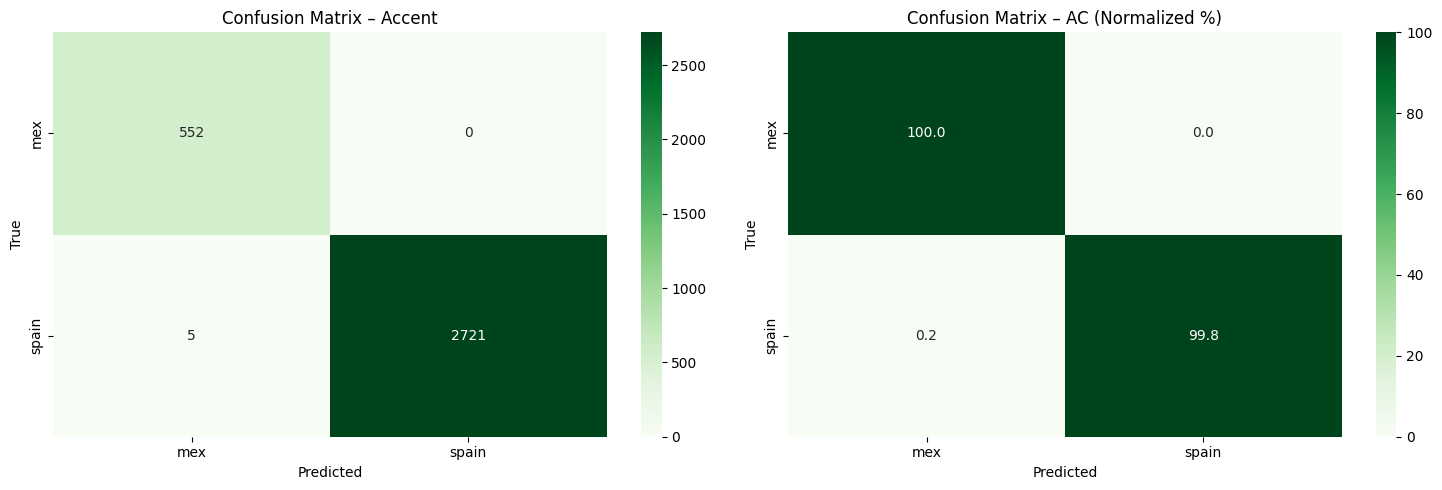

In [55]:
# --- Heatmap para acento ---
#--------------------------------------------------
#--------------------------------------------------
#--------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
cm_accent = confusion_matrix(accent_true, accent_pred, labels=range(len(accent_labels)))
cm_accent_norm = cm_accent.astype('float') / cm_accent.sum(axis=1, keepdims=True)

sns.heatmap(cm_accent, annot=True, fmt='d', 
            xticklabels=accent_labels, yticklabels=accent_labels, 
            cmap='Greens', ax=axes[0])
axes[0].set_title("Confusion Matrix – Accent")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_accent_norm * 100, annot=True, fmt='.1f',
            xticklabels=accent_labels, yticklabels=accent_labels, 
            cmap='Greens', ax=axes[1])
axes[1].set_title("Confusion Matrix – AC (Normalized %)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# Estilo general
plt.tight_layout()
plt.show()

C:\Users\AlxMa\AppData\Local\Temp\ipykernel_29988\1507970467.py:24: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
C:\Users\AlxMa\AppData\Local\Temp\ipykernel_29988\1507970467.py:24: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
C:\Users\AlxMa\AppData\Local\Temp\ipykernel_29988\1507970467.py:24: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
C:\Users\AlxMa\AppData\Local\Temp\ipykernel_29988\1507970467.py:24: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)


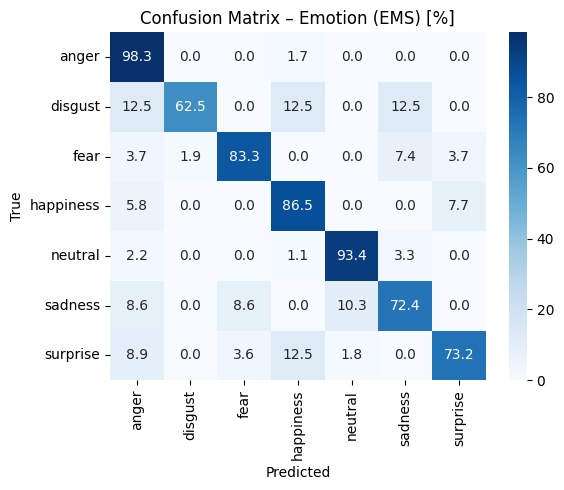

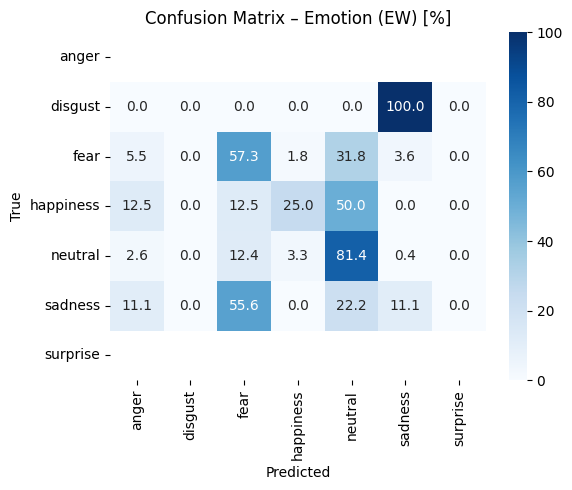

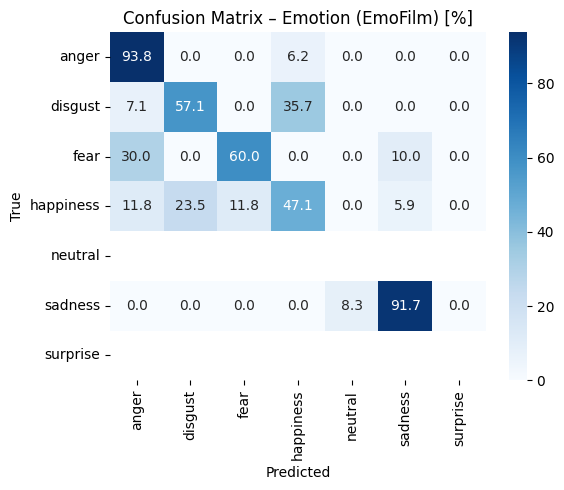

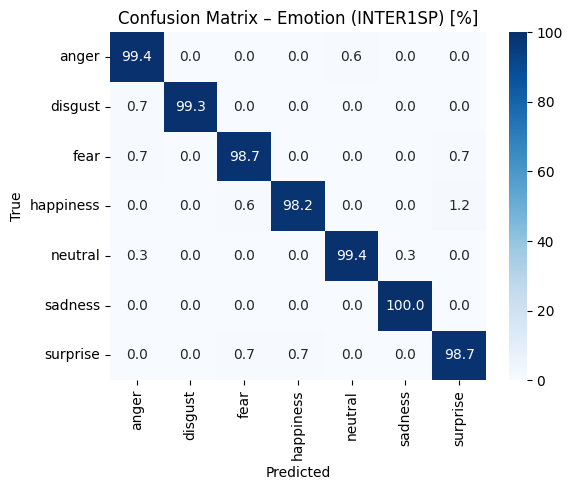

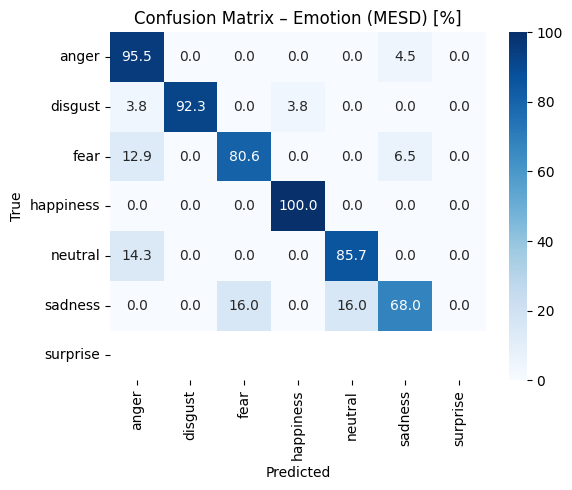

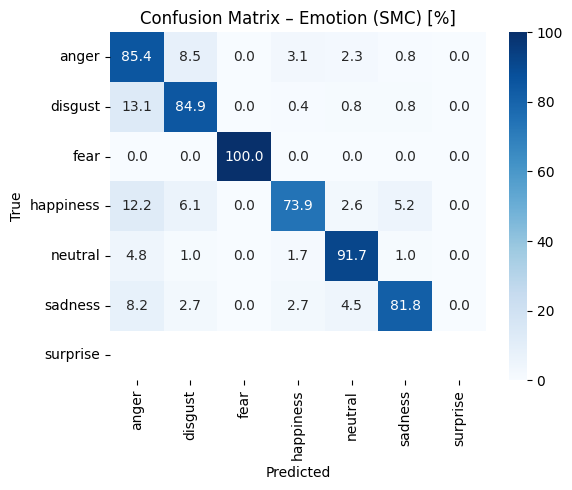

In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Base de datos correspondiente a cada muestra
databases = test_databases


# Diccionario para almacenar los heatmaps por base
conf_matrices = {}

for db in np.unique(databases):
    mask = databases == db
    
    # Filtrar por base
    emo_t = emotion_true[mask]
    emo_p = emotion_pred[mask]
    
    # Matriz bruta
    cm = confusion_matrix(emo_t, emo_p, labels=range(len(emotion_labels)))
    
    # Normalizar por filas (por clase real)
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    # Guardar
    conf_matrices[db] = cm_norm

for db in np.unique(databases):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrices[db] * 100, annot=True, fmt='.1f',
                xticklabels=emotion_labels, yticklabels=emotion_labels, cmap='Blues')
    plt.title(f"Confusion Matrix – Emotion ({db}) [%]")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    cm_emotion

---
---
# **Guardar resultados**

In [58]:
results = pd.DataFrame()

results[[l + '_test' for l in emotion_labels]] = y_test_emotions
results[[l + '_pred' for l in emotion_labels]] = y_pred_emotions

results[[l + '_test' for l in gender_labels]] = y_test_gender
results[[l + '_pred' for l in gender_labels]] = y_pred_gender

results[[l + '_test' for l in accent_labels]] = y_test_accent
results[[l + '_pred' for l in accent_labels]] = y_pred_accent


results.to_csv("preds_multioutput_augmented.csv")
results

,anger_test,disgust_test,fear_test,happiness_test,neutral_test,sadness_test,surprise_test,anger_pred,disgust_pred,fear_pred,...,child_test,female_test,male_test,child_pred,female_pred,male_pred,mex_test,spain_test,mex_pred,spain_pred
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3273,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3274,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3275,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3276,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
